Author: Carlos Roberto de Melo
    
Date: 07/11/2020

Obj: Parametrizar o perfil pseudo-NFW apresentado em Collett et al. 2018. A parametrização é feita com gaussianas, de modo que possam ser adicionadas ao potencial do JAM mais tarde.

In [1]:
from mgefit import mge_fit_1d
import matplotlib.pyplot as plt

In [2]:
import numpy as np

from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
from jampy.mge_half_light_isophote import mge_half_light_isophote
from jampy.mge_half_light_isophote import mge_half_light_radius

In [3]:
#Fris we will computhe the half ligth radius for the MGE parametrization
#Reading MGE parametrization

surf, sigma, qobs = np.loadtxt("/home/carlos/Documents/GitHub/Master-Degree/ESO325/Arcs Modelling/autolens_workspace/JAM+Pyautolens/Lab/JAM Input.txt", unpack=True)

In [4]:
#Distance to the galaxy in Mpc
distance = cosmo.angular_diameter_distance(0.035) 
distance

<Quantity 148.43688875 Mpc>

In [5]:
#Computing the half-light radius
reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(
                    surf, sigma, qobs, distance=distance)
reff_arc = reff*u.arcsec
reff_pc  = (reff_arc*distance).to(u.pc, u.dimensionless_angles())

print("Half-light radius, the  major axis and ellipticity of \n"+
              "the MGE isophote containing 1/2 of the analytic MGE total light.")

print(reff_arc)
print(reff_pc)

Half-light radius, the  major axis and ellipticity of 
the MGE isophote containing 1/2 of the analytic MGE total light.
4.757590842300747 arcsec
3423.763827737329 pc


In [6]:
##Computing the half-light radius using other approach
reff2, lum_tot2 = mge_half_light_radius(surf, sigma, qobs, distance)

print("Computes the circularized projected half-light radius of an \n"+
       "MGE model using the approach described after equation (11)\n"+
        "in Cappellari et al. (2013, MNRAS, 432, 1709)")

reff2_arc = reff2*u.arcsec
reff2_pc  = (reff2_arc*distance).to(u.pc, u.dimensionless_angles())

print(reff2_arc)
print(reff2_pc)

Computes the circularized projected half-light radius of an 
MGE model using the approach described after equation (11)
in Cappellari et al. (2013, MNRAS, 432, 1709)
4.758704254915497 arcsec
3424.56508660176 pc


In [7]:
#Definindo algumas funções úteis.
SQRT_TOW_PI = np.sqrt(2*np.pi)


#Perfil pseudo-NFW
def pNFW(rho_0, r_s, r):
    rho = rho_0/(r*(r_s**2 + r**2))
    return rho


In [8]:
reff_pc

<Quantity 3423.76382774 pc>

Iteration: 1  chi2: 0.03355 Nonzero: 58/100
Iteration: 9  chi2: 0.008512 Nonzero: 52/52
############################################
 Computation time: 266.83 seconds
 Total Iterations:  9
Nonzero Gaussians:  52
 Unused Gaussians:  48
 Chi2: 0.008512 
 STDEV: 0.001459
 MEANABSDEV: 0.0005089
############################################
 Total_Counts      Sigma
############################################
  1.28932e-09    0.0707107
  1.26515e-11     0.131982
  1.09529e-09     0.142654
  8.65109e-10     0.258369
   1.1246e-10     0.293883
  8.25314e-10     0.444214
  6.90407e-10     0.693896
   5.4648e-10     0.995819
  3.77806e-10      1.31409
   1.4814e-10      1.51243
  3.42343e-10      1.73298
  9.16418e-11      1.96609
   5.6912e-10      2.38766
  4.34389e-10      3.44242
  2.31186e-10      3.46799
  6.94478e-10      5.14958
  6.94094e-10      7.74637
  1.14255e-10      11.2515
  5.59673e-10      11.6438
  5.91451e-10      16.9307
  6.24026e-11       18.632
  2.68582e-10      24.5539

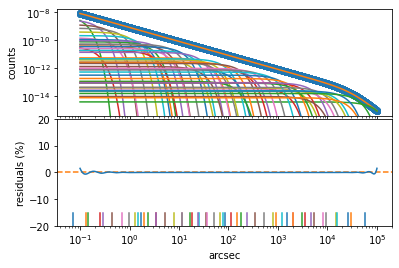

In [9]:
#Main code

#Definindo os parâmetros do gNFW
r_hl = reff_pc.value   #half light radius [pc]
rs = 10*r_hl           #rs do modelo, fixado pelo paper [pc]
rho_0 = 1.0            #[M_solar]  Obs:(1[M_solar/kpc^3] = 1e9[M_solar/pc^3])


#Agora vamos realizar a parametrização em MGE 1d
r_mge2d = np.logspace(np.log10(0.1), np.log10(10e4), 4000) #Cria valores espaçados em de um delta-log (requerido para o mge1d_fit)
rho_mge2d = pNFW(rho_0=rho_0, r_s=rs, r=r_mge2d) #Perfil gNFW

#-------------Aqui é onde realmente começa a parametrização MGE--------------------------------

mge = mge_fit_1d.mge_fit_1d(r_mge2d, rho_mge2d, quiet=False, ngauss=100, plot=True)
mge_peak = mge.sol[0]         #Pico de cada gaussiana
mge_sigma = mge.sol[1]        #Sigma de cada gaussiana
#O resultado acima já está em M_sun/pc²

mge2d = np.zeros((len(mge_peak), 3)) #Agora iremos criar um array com o número de linhas igual ao número de
                                        #gaussianas e três colunas para armazenar os dados
mge2d[:, 0] = mge_peak     #Pico de cada gaussiana
mge2d[:, 1] = mge_sigma    #Sigma de cada gausiana
mge2d[:, 2] = 0.74         #qObs de cada gaussiana. 

#plt.savefig("/home/carlos/Desktop/SDP/Dynamics/Jampy/Figs/pseudo-NFW_MGE_parametrization.png", fmt="png")

np.savetxt('pseudo-DM Input.txt', np.column_stack([mge2d[:, 0], mge2d[:,1]/(distance.value*np.pi/0.648),mge2d[:,2]]),
                            fmt=b'%10.6f\t\t\t %10.6f\t\t %10.6f', 
                            header='Surface Potential(M_sun/pc²) Sigma Potential(arcsec)    qObs')

#Aqui, quando salvamos o sigma de cada gaussiana dividimos pelo valor (distance*np.pi/0.648) pois o JAM requer 
    #que o sigma seja dado em arcsec. Nesta expressão 